# Import Libraries

In [1]:
# Import libraries
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger()

# Load and Preprocess Dataset

In [3]:
logger.info("Loading dataset...")
try:
    with open("datasetFix.json", "r", encoding="utf-8") as file:
        data = json.load(file)
    logger.info("Dataset successfully loaded.")
except FileNotFoundError:
    logger.error("Dataset file not found. Please check the file path.")
    exit()
except json.JSONDecodeError:
    logger.error("Dataset file is not a valid JSON. Please check the file format.")
    exit()

2024-11-24 19:08:20,223 - INFO - Loading dataset...
2024-11-24 19:08:20,270 - INFO - Dataset successfully loaded.


# Convert JSON to DataFrame

In [4]:
logger.info("Converting JSON to DataFrame...")
df = pd.DataFrame(data)

2024-11-24 19:08:20,286 - INFO - Converting JSON to DataFrame...


# Validate dataset

In [5]:
required_columns = ["description", "category"]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    logger.error(f"Dataset is missing required columns: {missing_columns}")
    exit()

logger.info("All required columns are present in the dataset.")

2024-11-24 19:08:20,337 - INFO - All required columns are present in the dataset.


# Check for missing values 

In [6]:
# Display and group categories for clarity
categories = sorted(df["category"].unique())
print(f"Categories: {categories}")

Categories: ['Bahasa Nusantara', 'Dongeng Nusantara', 'Kuliner Nusantara', 'Musik Nusantara', 'Pakaian Nusantara', 'Rumah Adat', 'Sejarah Nusantara', 'Seni dan Kerajinan', 'Tarian Nusantara', 'Tradisi Nusantara', 'Wisata Nusantara']


In [7]:
# Drop missing values
logger.info("Checking and dropping missing values...")
df = df.dropna(subset=required_columns)
logger.info(f"Dataset size after cleaning: {len(df)} rows.")


2024-11-24 19:08:20,477 - INFO - Checking and dropping missing values...
2024-11-24 19:08:20,486 - INFO - Dataset size after cleaning: 1095 rows.


In [8]:
# Preprocessing text
logger.info("Tokenizing text...")
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["description"])
X_seq = pad_sequences(tokenizer.texts_to_sequences(df["description"]), maxlen=100)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["category"])


2024-11-24 19:08:20,508 - INFO - Tokenizing text...


# Split dataset 

In [9]:
logger.info("Splitting dataset into train, validation, and test sets...")
X_seq = torch.tensor(X_seq, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

dataset = torch.utils.data.TensorDataset(X_seq, y)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2024-11-24 19:08:50,630 - INFO - Splitting dataset into train, validation, and test sets...


In [10]:
df.head()

,title,description,category,languageType,mediaURL
0,Tari Landek,Tarian tradisional Karo yang dilakukan dengan ...,Tarian Nusantara,Medan,None
1,Tari Piso Surit,Tarian yang menggambarkan suara burung Piso Su...,Tarian Nusantara,Medan,None
2,Tari Guro-Guro Aron,Tarian yang biasanya ditampilkan pada upacara ...,Tarian Nusantara,Medan,None
3,Ulos Karo,Kain tenun khas Karo yang memiliki motif unik ...,Seni dan Kerajinan,Medan,None
4,Anyaman Rotan,Kerajinan tangan dari rotan yang dibuat menjad...,Seni dan Kerajinan,Medan,None


In [11]:
# Grouping data by 'category'
category_groups = df.groupby("category").apply(
    lambda group: {
        "titles": group["title"].tolist(),
        "descriptions": group["description"].tolist(),
        "languageTypes": group["languageType"].tolist(),
        "mediaURLs": group["mediaURL"].tolist()
    }
).to_dict()

# Display category_groups
print(category_groups)

{'Bahasa Nusantara': {'titles': ['Mejuah-juah', 'Terem', 'Man', 'Nggak', 'Tedeh', 'Enda', 'Sude', 'Ibas', 'Piga', 'Ukur', 'Geluh', 'Poso', 'Mate', 'Ndahi', 'Mbelin', 'Empo', 'Ise', 'Kade-kade', 'Kerina', 'Entah', 'Tanding', 'Dekah', 'Jenda', 'Ginting', 'Ersinalsal', 'Langit', 'Tanah', 'Ijuk', 'Pedalan', 'La', 'Biring', 'Pica', 'Pitu', 'Jabu-jabu', 'Mangan', 'Minum', 'Bulung', 'Tedeh-tedeh', 'Gelas', 'Gantang', 'Kudingen', 'Kuta', 'Empu', 'Nakan', 'Mbiring', 'Talun', 'Lau', 'Perbadu', 'Darah', 'Tendina', 'Dilo', 'Tung-tung', 'Tangi', 'Entong', 'Gohi', 'Pengkih', 'Ertutur', 'Ngawan', 'Simbelin', 'Endeh', 'Kam', 'Kap', 'Perulak', 'Runggu', 'Gunung', 'Lau', 'Gancang', 'Sange', 'Sibuk', 'Erjuma', 'Perkakas', 'Jabu', 'Uruk', 'Lasa', 'Erkayit', 'Kencur', 'Erduan', 'Kutepi', 'Erkatak', 'Bulan', 'Matahari', 'Tawar', 'Singkap', 'Tungkus', 'Tambar', 'Ula', 'Sombah', 'Enteli', 'Lasi', 'Idahan', 'Sekolah', 'Sendiri', 'Peke', 'Peci', 'Relas', 'Turang', 'Erbuah', 'Pangarapan', 'Lembu', 'Ikan', 'Cikap

C:\Users\PF3S6\AppData\Local\Temp\ipykernel_34992\995754336.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_groups = df.groupby("category").apply(


In [12]:
# Updated display_category_summary function
def display_category_summary(category, group):
    print(f"Category: {category}")
    print("Items:")
    for title, desc, lang, url in zip(group["titles"], group["descriptions"], group["languageTypes"], group["mediaURLs"]):
        print(f"  - {title} ({lang}): {desc}")
        if url:
            print(f"    Media URL: {url}")
    print()

# Test the function
for category, group in category_groups.items():
    display_category_summary(category, group)

Category: Bahasa Nusantara
Items:
  - Mejuah-juah (Medan): Salam
  - Terem (Medan): Cantik
  - Man (Medan): Iya
  - Nggak (Medan): Tidak
  - Tedeh (Medan): Terima kasih
  - Enda (Medan): Ini
  - Sude (Medan): Semua
  - Ibas (Medan): Dalam
  - Piga (Medan): Berapa
  - Ukur (Medan): Besar
  - Geluh (Medan): Hidup
  - Poso (Medan): Anak kecil
  - Mate (Medan): Mati
  - Ndahi (Medan): Selamat tinggal
  - Mbelin (Medan): Mahal
  - Empo (Medan): Nenek
  - Ise (Medan): Siapa
  - Kade-kade (Medan): Teman
  - Kerina (Medan): Kita semua
  - Entah (Medan): Mungkin
  - Tanding (Medan): Pergi
  - Dekah (Medan): Dekat
  - Jenda (Medan): Sakit
  - Ginting (Medan): Keluarga Ginting
  - Ersinalsal (Medan): Berkumpul
  - Langit (Medan): Langit
  - Tanah (Medan): Tanah
  - Ijuk (Medan): Hitam
  - Pedalan (Medan): Jalan
  - La (Medan): Tidak ada
  - Biring (Medan): Pinggir
  - Pica (Medan): Potong
  - Pitu (Medan): Pintu
  - Jabu-jabu (Medan): Rumah
  - Mangan (Medan): Makan
  - Minum (Medan): Minum
  - B

# Define LSTM Model

In [13]:
# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.dropout(hidden[-1])
        return self.fc(x)

#  Hyperparameter tuning

In [14]:
# Hyperparameter tuning
logger.info("Starting hyperparameter tuning...")
learning_rates = [0.001, 0.005]
hidden_dims = [64, 128]
dropouts = [0.3, 0.5]
best_val_acc = 0
best_model_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 5000
output_dim = len(label_encoder.classes_)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            logger.info(f"Testing model with lr={lr}, hidden_dim={hidden_dim}, dropout={dropout}")
            
            # Membuat model LSTM dengan parameter yang diuji
            model = LSTMClassifier(vocab_size, 128, hidden_dim, output_dim, dropout).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(5):  # Keeping epochs low for tuning
                model.train()
                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                # Evaluate on validation set
                model.eval()
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    for X_val, y_val in val_loader:
                        X_val, y_val = X_val.to(device), y_val.to(device)
                        outputs = model(X_val)
                        _, predicted = torch.max(outputs, 1)
                        val_correct += (predicted == y_val).sum().item()
                        val_total += y_val.size(0)

                val_acc = val_correct / val_total
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    # Simpan parameter terbaik dengan validasi yang lebih ketat
                    best_model_params = (model.state_dict(), lr, hidden_dim, dropout)

# Menampilkan hasil terbaik
logger.info(f"Best validation accuracy: {best_val_acc}")
logger.info(f"Best model params: {best_model_params}")

# Load best model with the best parameters
if best_model_params is not None:
    # Memastikan hidden_dim dan dropout yang valid
    hidden_dim = best_model_params[2] if best_model_params[2] > 0 else 128
    dropout = best_model_params[3] if best_model_params[3] > 0 else 0.3
    logger.info(f"Using hidden_dim={hidden_dim} and dropout={dropout} for best model.")

    # Load the model with the best parameters
    model = LSTMClassifier(vocab_size, 128, hidden_dim, output_dim, dropout).to(device)
    model.load_state_dict(best_model_params[0])  # Memuat state_dict model terbaik
else:
    logger.error("No valid model found during hyperparameter tuning.")

2024-11-24 19:08:50,952 - INFO - Starting hyperparameter tuning...
2024-11-24 19:08:50,952 - INFO - Testing model with lr=0.001, hidden_dim=64, dropout=0.3
2024-11-24 19:09:03,029 - INFO - Testing model with lr=0.001, hidden_dim=64, dropout=0.5
2024-11-24 19:09:07,779 - INFO - Testing model with lr=0.001, hidden_dim=128, dropout=0.3
2024-11-24 19:09:16,390 - INFO - Testing model with lr=0.001, hidden_dim=128, dropout=0.5
2024-11-24 19:09:24,592 - INFO - Testing model with lr=0.005, hidden_dim=64, dropout=0.3
2024-11-24 19:09:29,965 - INFO - Testing model with lr=0.005, hidden_dim=64, dropout=0.5
2024-11-24 19:09:37,660 - INFO - Testing model with lr=0.005, hidden_dim=128, dropout=0.3
2024-11-24 19:10:02,641 - INFO - Testing model with lr=0.005, hidden_dim=128, dropout=0.5
2024-11-24 19:10:36,443 - INFO - Best validation accuracy: 0.8841463414634146
2024-11-24 19:10:36,475 - INFO - Best model params: (OrderedDict([('embedding.weight', tensor([[ 0.0169, -0.0580, -1.8777,  ..., -0.8891,  

In [15]:
# Test set evaluation
logger.info("Evaluating on test set...")
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

2024-11-24 19:10:36,545 - INFO - Evaluating on test set...


In [16]:
from sklearn.metrics import classification_report

# Pastikan label yang digunakan sesuai dengan target yang ada
logger.info("\nClassification Report:\n" + classification_report(y_true, y_pred, 
                                                              target_names=label_encoder.classes_[:10],  # Menyesuaikan dengan 10 kelas yang digunakan
                                                              labels=label_encoder.transform(label_encoder.classes_[:10])))  # Gunakan transformasi untuk mencocokkan label

c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

2024-11-24 19:10:37,538 - INFO - Generating confusion matrix...


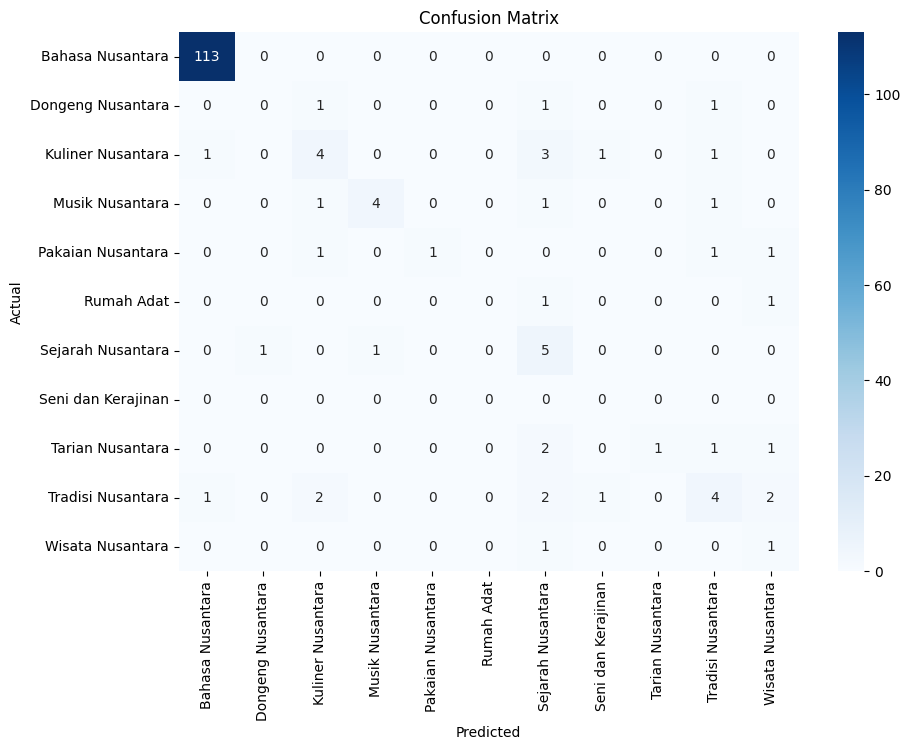

In [17]:
# Confusion Matrix
logger.info("Generating confusion matrix...")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

2024-11-24 19:10:40,142 - INFO - Generating ROC curve...


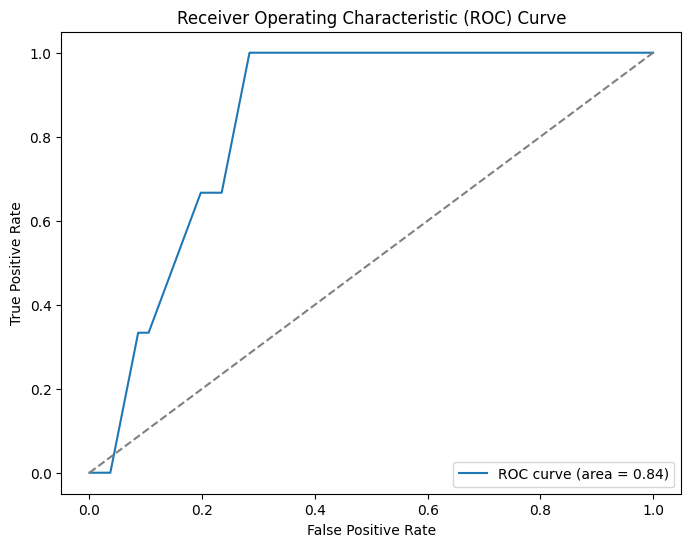

In [18]:
# ROC Curve
logger.info("Generating ROC curve...")
fpr, tpr, _ = roc_curve(y_true, np.array(y_pred), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [19]:
# Save the model
logger.info("Saving the best model...")
torch.save(model.state_dict(), "lstm_model.pt")
logger.info("Model saved as lstm_model.pt.")

2024-11-24 19:10:41,150 - INFO - Saving the best model...
2024-11-24 19:10:41,166 - INFO - Model saved as lstm_model.pt.


# TF-IDF vectorization

In [20]:
logger.info(f"Train dataset size: {len(train_dataset)}")
logger.info(f"Validation dataset size: {len(val_dataset)}")
logger.info(f"Test dataset size: {len(test_dataset)}")

2024-11-24 19:10:41,183 - INFO - Train dataset size: 766
2024-11-24 19:10:41,185 - INFO - Validation dataset size: 164
2024-11-24 19:10:41,186 - INFO - Test dataset size: 165


In [21]:
for batch in train_loader:
    X_batch, y_batch = batch
    logger.info(f"First batch X: {X_batch.shape}, y: {y_batch.shape}")
    break  

2024-11-24 19:10:41,209 - INFO - First batch X: torch.Size([32, 100]), y: torch.Size([32])


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader

df['text'] = df['title'] + " " + df['description']

# Ambil kolom 'text' sebagai X (fitur) dan kolom 'category' sebagai y (label)
X = df['text'].values
y = df['category'].values

# Jika kategori masih berupa teks, kita perlu mengubahnya menjadi label numerik
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Mengubah kategori menjadi angka

# Bagi dataset menjadi train, validation, dan test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% untuk train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% dari sisa untuk val dan test

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit dan transform pada X_train
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform pada X_val dan X_test menggunakan fitur yang sama
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Ubah hasil menjadi tensor
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_val_tfidf = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Membuat TensorDataset untuk train, val, dan test sets
train_dataset = TensorDataset(X_train_tfidf, torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(X_val_tfidf, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tfidf, torch.tensor(y_test, dtype=torch.long))

# Membuat DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
logger.info("Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

2024-11-24 19:10:41,483 - INFO - Vectorizing text using TF-IDF...


In [24]:
import joblib  

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
logger.info("TF-IDF Vectorizer saved.")

2024-11-24 19:10:41,702 - INFO - TF-IDF Vectorizer saved.


# Logistic Regression Model with Hyperparameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV  
from sklearn.linear_model import LogisticRegression 

# Performing hyperparameter tuning for Logistic Regression...
logger.info("Performing hyperparameter tuning for Logistic Regression...")
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500]
}

grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial'),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_tfidf, y_train)

best_model = grid_search.best_estimator_
logger.info(f"Best model parameters: {grid_search.best_params_}")

2024-11-24 19:10:42,090 - INFO - Performing hyperparameter tuning for Logistic Regression...


c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PF3S6\AppDat

In [26]:
# Evaluate on Validation Set
logger.info("Evaluating on validation set...")
y_val_pred = best_model.predict(X_val_tfidf)
val_report = classification_report(y_val, y_val_pred)
logger.info("\nValidation Set Classification Report:\n" + val_report)

2024-11-24 19:10:58,739 - INFO - Evaluating on validation set...
2024-11-24 19:10:58,769 - INFO - 
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       123
           2       1.00      0.70      0.82        10
           3       1.00      0.50      0.67         6
           4       1.00      1.00      1.00         2
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
           9       0.60      1.00      0.75         3
          10       1.00      1.00      1.00         5

    accuracy                           0.95       164
   macro avg       0.96      0.84      0.87       164
weighted avg       0.96      0.95      0.95       164



In [27]:
# Final Evaluation on Test Set
logger.info("Evaluating on test set...")
y_test_pred = best_model.predict(X_test_tfidf)
test_report = classification_report(y_test, y_test_pred)
logger.info("\nTest Set Classification Report:\n" + test_report)

2024-11-24 19:10:58,791 - INFO - Evaluating on test set...
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

In [28]:
# Save the trained model
joblib.dump(best_model, "logistic_regression_model.pkl")
logger.info("Trained model saved as logistic_regression_model.pkl.")

2024-11-24 19:10:58,823 - INFO - Trained model saved as logistic_regression_model.pkl.


# Split into training and testing sets

In [29]:
print("Splitting into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Splitting into training and testing sets...


# Vectorize text data using TF-IDF

In [30]:
print("Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Vectorizing text using TF-IDF...


# Train a Logistic Regression model

In [31]:
print("Training Logistic Regression model...")
model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train_tfidf, y_train)

Training Logistic Regression model...


LogisticRegression(max_iter=1000, multi_class='multinomial')

# Evaluate the model

In [32]:
print("Evaluating model performance...")
y_pred = model.predict(X_test_tfidf)

Evaluating model performance...


In [33]:
# Classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("\nClassification Report:")
print(report)


Classification Report:
                    precision    recall  f1-score   support

  Bahasa Nusantara       0.82      1.00      0.90       165
 Dongeng Nusantara       0.00      0.00      0.00         1
 Kuliner Nusantara       1.00      0.38      0.55         8
   Musik Nusantara       0.67      0.40      0.50         5
 Pakaian Nusantara       1.00      0.75      0.86         4
        Rumah Adat       1.00      0.33      0.50         3
 Sejarah Nusantara       1.00      0.50      0.67        12
Seni dan Kerajinan       0.00      0.00      0.00         3
  Tarian Nusantara       0.00      0.00      0.00         3
 Tradisi Nusantara       0.50      0.12      0.20         8
  Wisata Nusantara       0.00      0.00      0.00         7

          accuracy                           0.83       219
         macro avg       0.54      0.32      0.38       219
      weighted avg       0.78      0.83      0.78       219



c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PF3S6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [34]:
from sklearn.metrics import confusion_matrix

# Periksa label yang ada dalam y_test dan y_pred
unique_labels = sorted(set(y_test) | set(y_pred))

# Confusion matrix dengan label yang valid
print("Generating confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Tampilkan matriks kebingungannya
print(conf_matrix)

Generating confusion matrix...
[[165   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0]
 [  5   0   3   0   0   0   0   0   0   0   0]
 [  3   0   0   2   0   0   0   0   0   0   0]
 [  1   0   0   0   3   0   0   0   0   0   0]
 [  2   0   0   0   0   1   0   0   0   0   0]
 [  6   0   0   0   0   0   6   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   1   0   0   0   0   0   1   0]
 [  7   0   0   0   0   0   0   0   0   1   0]
 [  7   0   0   0   0   0   0   0   0   0   0]]


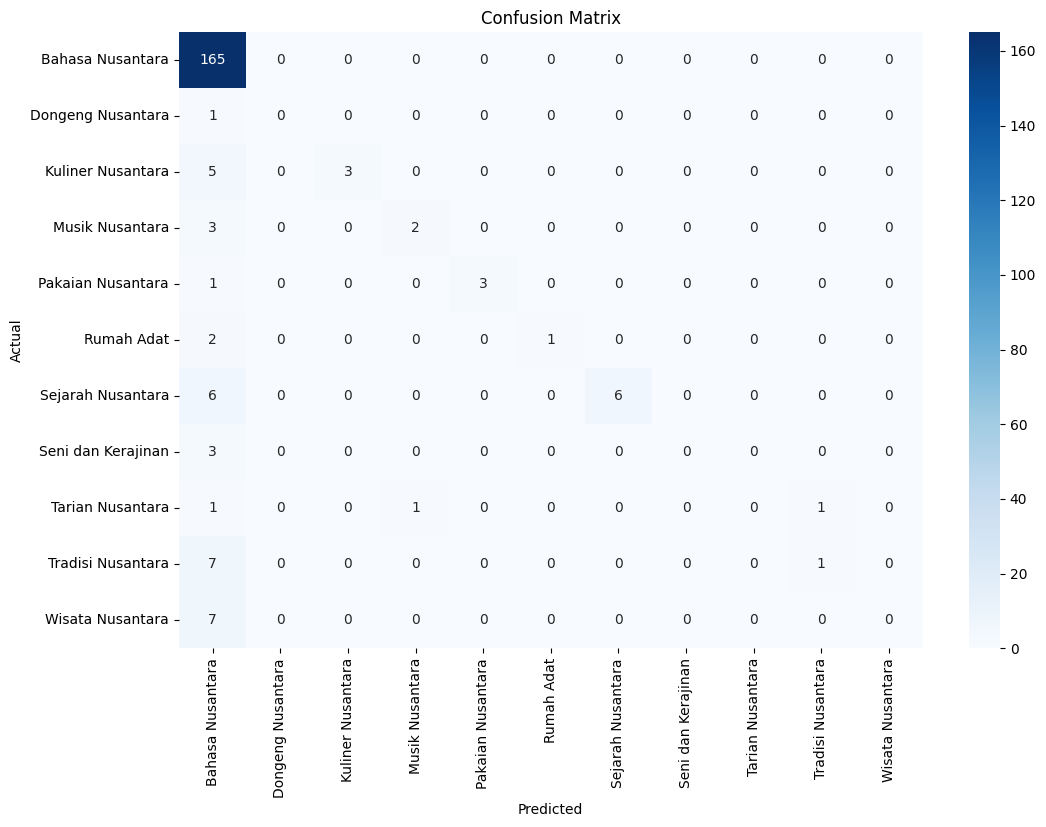

In [35]:
# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    xticklabels=categories,
    yticklabels=categories,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the processed dataset, model, and vectorizer

In [36]:
print("Saving processed dataset, model, and vectorizer...")
df.to_csv("processed_dataset.csv", index=False)
joblib.dump(model, "cultural_classifier_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("All files have been saved successfully.")


Saving processed dataset, model, and vectorizer...
All files have been saved successfully.


In [37]:
# Summary of steps
print("\n--- SUMMARY ---")
print("1. Dataset loaded and processed.")
print(f"2. Found {len(categories)} categories.")
print("3. Model trained using Logistic Regression.")
print("4. Model evaluation completed with classification report and confusion matrix.")
print("5. Files saved: 'processed_dataset.csv', 'cultural_classifier_model.pkl', 'tfidf_vectorizer.pkl'.")


--- SUMMARY ---
1. Dataset loaded and processed.
2. Found 11 categories.
3. Model trained using Logistic Regression.
4. Model evaluation completed with classification report and confusion matrix.
5. Files saved: 'processed_dataset.csv', 'cultural_classifier_model.pkl', 'tfidf_vectorizer.pkl'.


# Logging dan Monitoring

In [38]:
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger()

# Ganti semua print dengan logger
logger.info("Loading dataset...")


2024-11-24 19:11:01,630 - INFO - Loading dataset...


# Validasi Kolom yang Diperlukan

In [39]:
# Kolom yang wajib ada dalam dataset
required_columns = ["description", "category"]

# Validasi kolom dalam DataFrame
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    logger.error(f"Dataset is missing required columns: {missing_columns}")
    exit()
else:
    logger.info("All required columns are present in the dataset.")


2024-11-24 19:11:01,662 - INFO - All required columns are present in the dataset.


In [40]:
logger.info("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

logger.info(f"Train set: {len(X_train)} samples, Validation set: {len(X_val)} samples, Test set: {len(X_test)} samples")


2024-11-24 19:11:01,676 - INFO - Splitting dataset into train, validation, and test sets...
2024-11-24 19:11:01,685 - INFO - Train set: 766 samples, Validation set: 164 samples, Test set: 165 samples


In [41]:
logger.info("Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)

# Fit-transform untuk training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform validation dan test data menggunakan vectorizer yang sama
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)



2024-11-24 19:11:01,704 - INFO - Vectorizing text using TF-IDF...


In [42]:
logger.info(f"Features in X_train: {X_train_tfidf.shape[1]}")
logger.info(f"Features in X_val: {X_val_tfidf.shape[1]}")
logger.info(f"Features in X_test: {X_test_tfidf.shape[1]}")

if X_train_tfidf.shape[1] != X_val_tfidf.shape[1] or X_train_tfidf.shape[1] != X_test_tfidf.shape[1]:
    logger.error("Feature mismatch detected. Ensure TF-IDF vectorizer is used consistently.")
    exit()


2024-11-24 19:11:01,772 - INFO - Features in X_train: 2291
2024-11-24 19:11:01,772 - INFO - Features in X_val: 2291
2024-11-24 19:11:01,772 - INFO - Features in X_test: 2291


In [43]:
import re

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    return text

In [44]:
# Convert numpy arrays to pandas Series
X_train = pd.Series(X_train)
X_val = pd.Series(X_val)
X_test = pd.Series(X_test)

# Apply the preprocessing to each element
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [45]:
logger.info("Checking for missing values...")
logger.info(f"Missing values in X_train: {X_train.isnull().sum()}")
logger.info(f"Missing values in X_val: {X_val.isnull().sum()}")
logger.info(f"Missing values in X_test: {X_test.isnull().sum()}")


2024-11-24 19:11:01,866 - INFO - Checking for missing values...
2024-11-24 19:11:01,866 - INFO - Missing values in X_train: 0
2024-11-24 19:11:01,866 - INFO - Missing values in X_val: 0
2024-11-24 19:11:01,866 - INFO - Missing values in X_test: 0


In [46]:
logger.info("Sample data after preprocessing:")
logger.info(f"X_train sample: {X_train.head()}")
logger.info(f"X_val sample: {X_val.head()}")
logger.info(f"X_test sample: {X_test.head()}")


2024-11-24 19:11:01,893 - INFO - Sample data after preprocessing:
2024-11-24 19:11:01,895 - INFO - X_train sample: 0                                           emmĕ telan
1                                            erat kuat
2                                          bulu gunung
3    babi panggang karo daging babi yang dipanggang...
4                                           lau sungai
dtype: object
2024-11-24 19:11:01,895 - INFO - X_val sample: 0                                         reken hitung
1                                        abbeang buang
2                                   turangku saudaraku
3                                         huleng bulan
4    ah sa tadi ada liat mo ko sama dia jalan ah ta...
dtype: object
2024-11-24 19:11:01,898 - INFO - X_test sample: 0    jayapura kota jayapura bersebelahan dengan kab...
1    cawir metua upacara adat ketika seorang kepala...
2                                perpelangen perbedaan
3    desa wamena terletak di lembah baliem desa

In [47]:
tfidf = TfidfVectorizer(max_features=5000)